# Dataproc Lab

This lab covers:<br>
    1. Apache Spark BigQuery connector<br>
    2. External tables (Parquet) with Dataproc Metastore Service<br>

## Part 1. Chicago Crimes Analysis against BigQuery using Apache Spark connector for BigQuery

### 1) Create a Spark sesssion

In [118]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
  .appName("Chicago Crimes Analysis")\
  .master("yarn")\
  .enableHiveSupport()\
  .getOrCreate()

In [119]:
spark

### 2) Load data from a public dataset into a dataframe

In [120]:
# Read data from BigQuery
baseDF = spark.read \
  .format('bigquery') \
  .load('bigquery-public-data.chicago_crime.crime')

In [121]:
# Print schema
baseDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



In [122]:
display(baseDF.show(3,truncate=False))

+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+-----------------------------+
|unique_key|case_number|date               |block           |iucr|primary_type|description        |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on         |latitude    |longitude    |location                     |
+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+-----------------------------+
|24322     |JB536039   |2018-12-01 02:39:00|000XX W 103RD ST|0110|HOMICIDE    |FIRST DEGREE MURDER|STREET              |true  |false   |

None

In [123]:
baseDF.createOrReplaceTempView("chicago_crimes_raw")

### 3) Transform the dataset

#### 3.1. Deduplicate

In [124]:
# 3.1.a. Read raw crimes into a dataframe
rawDF=spark.sql("select * from chicago_crimes_raw")

In [125]:
# 3.1.b. Dedupe the data
dedupedRawDF=rawDF.dropDuplicates()

In [126]:
dedupedRawDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



#### 3.2. Augment the data with temporal attributes

In [127]:
# 3.2.a. Create a UDF to return day of the week
from pyspark.sql.types import *
from pyspark.sql.functions import *

def getDayNameFromWeekdayNbr(weekday):
    if weekday == 0:
        return "Monday"
    if weekday == 1:
        return "Tuesday"
    if weekday == 2:
        return "Wednesday"
    if weekday == 3:
        return "Thursday"
    if weekday == 4:
        return "Friday"
    if weekday == 5:
        return "Saturday"
    if weekday == 6:
        return "Sunday"

udf_getDayNameFromWeekdayNbr = udf(getDayNameFromWeekdayNbr, StringType())

In [128]:
# 3.2.b. Add a column case_timestamp with case_dt_tm formatted to timestamp and create a temporary view on this
augmentedDF=spark.sql("select * from chicago_crimes_raw").withColumn("case_timestamp",to_timestamp("date","MM/dd/yyyy hh:mm:ss"))

In [129]:
augmentedDF.createOrReplaceTempView("crimes_raw_temp_with_timestamp")

In [130]:
augmentedDF.show(2)

+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+-------------------+
|unique_key|case_number|               date|           block|iucr|primary_type|        description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|     case_timestamp|
+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+-------------------+
|     24322|   JB536039|2018-12-01 02:39:00|000XX W 103RD ST|0110|    HOMICIDE|FIRST DEGREE MURDER|    

In [131]:
augmentedDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- case_timestamp: timestamp (nullable = true)



In [132]:
# 3.2.c. Add some temporal attributes using Spark date features
curatedInitialDF = spark.sql("select *, month(case_timestamp) as case_month,dayofmonth(case_timestamp) as case_day_of_month, hour(case_timestamp) as case_hour, dayofweek(case_timestamp) as case_day_of_week_nbr from crimes_raw_temp_with_timestamp")

In [133]:
curatedInitialDF.show(2)

+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+-------------------+----------+-----------------+---------+--------------------+
|unique_key|case_number|               date|           block|iucr|primary_type|        description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|    latitude|    longitude|            location|     case_timestamp|case_month|case_day_of_month|case_hour|case_day_of_week_nbr|
+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+--------------------+----

In [134]:
# 3.2.d. Lets use the UDF we created to add the day of the week name
curatedDF=curatedInitialDF.withColumn("case_day_of_week_name",udf_getDayNameFromWeekdayNbr("case_day_of_week_nbr"))

In [135]:
curatedDF.printSchema()

root
 |-- unique_key: long (nullable = false)
 |-- case_number: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: long (nullable = true)
 |-- district: long (nullable = true)
 |-- ward: long (nullable = true)
 |-- community_area: long (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: long (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- case_timestamp: timestamp (nullable = true)
 |-- case_month: integer (nullable = true)
 |-- case_

In [136]:
curatedDF.show(2,truncate=False)

+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+-------------------+------------+-------------+-----------------------------+-------------------+----------+-----------------+---------+--------------------+---------------------+
|unique_key|case_number|date               |block           |iucr|primary_type|description        |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on         |latitude    |longitude    |location                     |case_timestamp     |case_month|case_day_of_month|case_hour|case_day_of_week_nbr|case_day_of_week_name|
+----------+-----------+-------------------+----------------+----+------------+-------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------

In [137]:
curatedDF.createOrReplaceTempView("chicago_crimes_temp_view")

### 4) Analyze crimes

#### 4.1. Crimes by year

In [138]:
crimesByYearDF=spark.sql("SELECT year,count(*) AS crime_count FROM chicago_crimes_temp_view GROUP BY year ORDER BY year;")
crimesByYearDF.show()

+----+-----------+
|year|crime_count|
+----+-----------+
|2001|     485862|
|2002|     486799|
|2003|     475979|
|2004|     469417|
|2005|     453764|
|2006|     448170|
|2007|     437079|
|2008|     427159|
|2009|     392817|
|2010|     370487|
|2011|     351952|
|2012|     336249|
|2013|     307449|
|2014|     275719|
|2015|     264721|
|2016|     269765|
|2017|     269023|
|2018|     268718|
|2019|     261178|
|2020|     211981|
+----+-----------+
only showing top 20 rows



In [139]:
# Convert results to a Pandas dataframe for visualization
crimesByYearPDF = crimesByYearDF.toPandas()

In [140]:
crimesByYearPDF

,year,crime_count
0,2001,485862
1,2002,486799
2,2003,475979
3,2004,469417
4,2005,453764
5,2006,448170
6,2007,437079
7,2008,427159
8,2009,392817
9,2010,370487


In [141]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='year'>

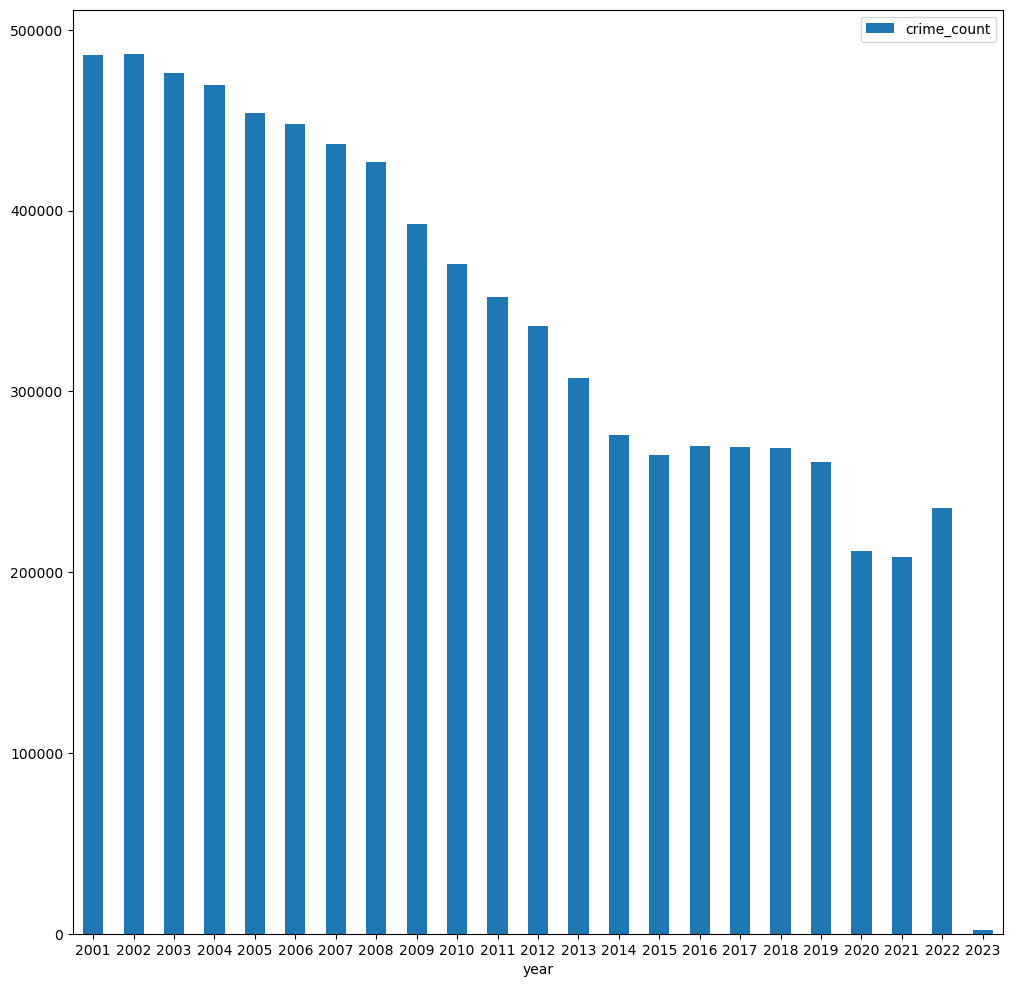

In [142]:
crimesByYearPDF.plot.bar(x='year', y='crime_count', rot=0,figsize=(12, 12))

#### 4.2. Crimes count by day

In [143]:

crimesByDayDF=spark.sql("SELECT case_day_of_week_name as day,count(*) AS crime_count FROM chicago_crimes_temp_view GROUP BY case_day_of_week_name ORDER BY case_day_of_week_name;")
crimesByDayDF.show()

+---------+-----------+
|      day|crime_count|
+---------+-----------+
|     null|    1104344|
|   Friday|    1108859|
| Saturday|    1097627|
|   Sunday|    1158608|
| Thursday|    1102272|
|  Tuesday|    1048548|
|Wednesday|    1089989|
+---------+-----------+



In [144]:
# Convert results to a Pandas dataframe for visualization
crimesByDayPDF = crimesByDayDF.toPandas()

<AxesSubplot:title={'center':'Crimes by day of week'}, ylabel='crime_count'>

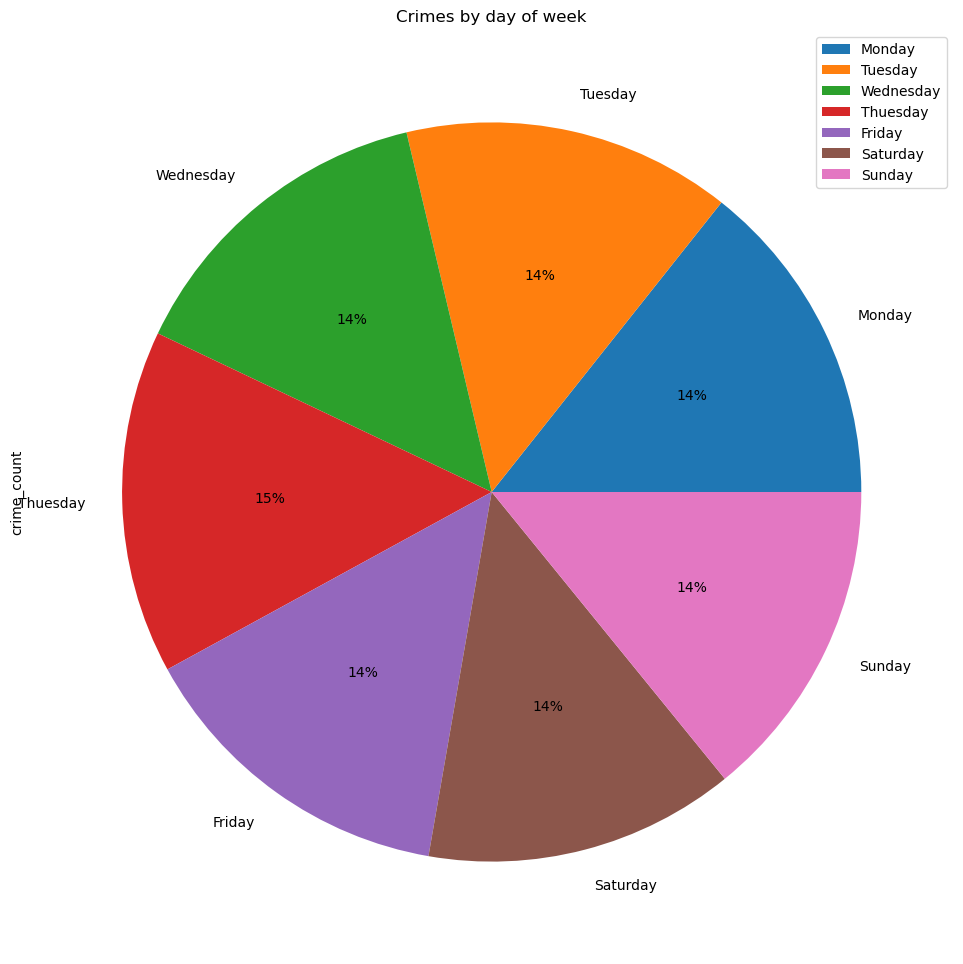

In [145]:
crimesByDayPDF.plot.pie(y='crime_count', x='day', figsize=(12,12),title='Crimes by day of week', labels = ['Monday','Tuesday','Wednesday','Thuesday','Friday','Saturday','Sunday'],autopct='%1.0f%%')

In [146]:
STOP - deliberately

NameError: name 'STOP' is not defined

## Part 2: Dataproc Metastore Lab

### 2.1. Create a database in the Dataproc Metastore

In [ ]:
spark.sql("CREATE DATABASE IF NOT EXISTS crimes_db").show(truncate=False)

In [ ]:
spark.sql("SHOW DATABASES").show()

In [ ]:
STOP - deliberately

### 2.2. Persist Chicago Crimes to your Data Lake on Cloud Storage & register in DPMS

In [ ]:
project_id_output = !gcloud config list --format "value(core.project)" 2>/dev/null
PROJECT_ID = project_id_output[0]
print("PROJECT_ID: ", PROJECT_ID)

In [ ]:
project_number_output = !gcloud projects describe $PROJECT_ID | grep projectNumber | cut -d':' -f2 | xargs
PROJECT_NUMBER = project_number_output[0]
print("PROJECT_NUMBER: ", PROJECT_NUMBER)

In [ ]:
crimesDataLakeRootDir = f"gs://dpgce-spark-bucket-{PROJECT_NUMBER}/crimes-data-lake"
print(crimesDataLakeRootDir)

In [ ]:
crimesDataLakeParquetTableLocation = f"{crimesDataLakeRootDir}/parquet-table"
print(crimesDataLakeParquetTableLocation)

crimesParquetTable = "crimes_db.chicago_crimes_curated_parquet"
print(crimesParquetTable)

In [ ]:
curatedDF.write.mode("overwrite").partitionBy("year").option("path",f"{crimesDataLakeParquetTableLocation}").saveAsTable(crimesParquetTable)

In [ ]:
STOP - deliberately

### 2.3. Query the external table registered in DPMS

In [ ]:
spark.sql("SHOW TABLES IN crimes_db").show(truncate=False)

In [ ]:
spark.sql("DESCRIBE FORMATTED crimes_db.chicago_crimes_curated_parquet").show(truncate=False)

In [ ]:
spark.sql("select year, count(*) as crimes_count from crimes_db.chicago_crimes_curated_parquet group by year").show(truncate=False)

In [ ]:
STOP - deliberately